In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import os
from PIL import Image
import numpy as np

In [28]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224),  # Random resize and crop
    transforms.RandomAffine(10, shear=10),  # Random affine transformations
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [29]:

# Define the label mapping
class_label_mapping = {
    'Actinic keratosis': 0,
    'Atopic Dermatitis': 1,
    'Benign keratosis': 2,
    'Dermatofibroma': 3,
    'Melanocytic nevus': 4,
    'Melanoma': 5,
    'Squamous cell carcinoma': 6,
    'Vascular lesion': 7
}

In [30]:
class SkinDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Loop over the classes and gather image paths
        for class_name in os.listdir(root_dir):
            if class_name in class_label_mapping:  # Only process classes in the label mapping
                class_path = os.path.join(root_dir, class_name)
                for img_name in os.listdir(class_path):
                    self.image_paths.append(os.path.join(class_path, img_name))
                    self.labels.append(class_label_mapping[class_name])
                
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [31]:
# Dataset and DataLoader
train_data = SkinDiseaseDataset(root_dir='data', transform=transform)

# Split dataset into training and validation
val_split = 0.2
val_size = int(len(train_data) * val_split)
train_size = len(train_data) - val_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# VGG-16 Model with feature extraction and fine-tuning
model = models.vgg16(pretrained=True)

# Unfreeze some of the convolutional layers
for param in model.features[:30].parameters():  # Unfreeze the first 30 layers
    param.requires_grad = True

# Add Dropout to the classifier
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[0].in_features, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, len(class_label_mapping)),  # Number of classes
)

In [32]:
# Use GPU for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()

# Optimizer: Use a lower learning rate for the feature extractor and a higher one for the classifier
optimizer = optim.Adam([
    {'params': model.features.parameters(), 'lr': 1e-5},  # Low LR for the feature extractor
    {'params': model.classifier.parameters(), 'lr': 1e-4}  # Higher LR for the classifier
])

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Function to calculate metrics
def calculate_metrics(true_labels, predictions):
    accuracy = (np.array(true_labels) == np.array(predictions)).sum() / len(true_labels)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    cm = confusion_matrix(true_labels, predictions)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(cm)

# Training Loop
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    true_labels = []
    predictions = []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_acc = (np.array(true_labels) == np.array(predictions)).mean()
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_true = []
    val_pred = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(predicted.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_acc = (np.array(val_true) == np.array(val_pred)).mean()
    
    # Print metrics after each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}')
    
    # Calculate and print metrics after each epoch
    calculate_metrics(true_labels, predictions)
    
    # Step the scheduler
    scheduler.step(val_loss)

Epoch [1/40], Loss: 1.7549, Validation Loss: 1.3247
Accuracy: 0.3349
Precision: 0.3358
Recall: 0.3349
F1 Score: 0.3305
Confusion Matrix:
[[24  1  3  9  2  6 15 13]
 [ 4 51  5  3  4  2  5  7]
 [ 7  3 23 12  4 12  6 14]
 [12  3 11 18  6  8 11 15]
 [ 4  8 11  7 20 12  3 11]
 [11  7 14  5 12 18  9  8]
 [23  2  9  9  1 10 20 10]
 [ 8  5  7 10  1  4  3 41]]
Epoch [2/40], Loss: 1.1683, Validation Loss: 1.0598
Accuracy: 0.5374
Precision: 0.5427
Recall: 0.5374
F1 Score: 0.5375
Confusion Matrix:
[[39  0  1 11  0  0 21  1]
 [ 0 70  1  1  1  7  0  1]
 [ 2  2 51  9  3 10  4  0]
 [ 4  0  8 40  2  2 18 10]
 [ 1  2  8  7 20 32  4  2]
 [ 4  2 12  8 17 36  4  1]
 [28  1  3  9  4  6 32  1]
 [ 0  0  0 14  3  2  3 57]]
Epoch [3/40], Loss: 0.9837, Validation Loss: 1.2914
Accuracy: 0.6449
Precision: 0.6476
Recall: 0.6449
F1 Score: 0.6421
Confusion Matrix:
[[45  0  1  4  1  0 22  0]
 [ 0 78  1  0  0  2  0  0]
 [ 1  0 62  4  6  4  4  0]
 [ 6  0  5 37  1  6 19 10]
 [ 0  1  2  2 45 19  6  1]
 [ 2  3  6  2 30 30 

In [34]:
# Save the model
torch.save(model.state_dict(), 'morning.pth')

In [41]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np

# Define the label mapping (should match training label mapping)
class_label_mapping = {
    0: 'Actinic keratosis',
    1: 'Atopic Dermatitis',
    2: 'Benign keratosis',
    3: 'Dermatofibroma',
    4: 'Melanocytic nevus',
    5: 'Melanoma',
    6: 'Squamous cell carcinoma',
    7: 'Vascular lesion'
}

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.vgg16(pretrained=True)

# Adjust the classifier to match training setup
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[0].in_features, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, len(class_label_mapping))  # Number of classes
)

# Load trained weights
model.load_state_dict(torch.load('morning.pth', map_location=device))
model = model.to(device)
model.eval()

# Define the same preprocessing steps used for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to predict the class of an unseen image
def predict_skin_disease(image_path, model, transform, class_label_mapping):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the appropriate device
    image = image.to(device)

    # Get the model's prediction
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)

    # Get the class name from the label mapping
    class_name = class_label_mapping[predicted_class.item()]
    return class_name

# Test the model with an unseen image
image_path = 'atd.jpg'  # Replace with the path to your test image
predicted_class = predict_skin_disease(image_path, model, transform, class_label_mapping)

print(f'The predicted class for the given image is: {predicted_class}')


c:\Users\admin\anaconda3\envs\pytor-malar\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\anaconda3\envs\pytor-malar\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\admin\AppData\Local\Temp\ipykernel_15844\999231299.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pyto

The predicted class for the given image is: Atopic Dermatitis



Train Data Evaluation:
Evaluating Model: VGG


<Figure size 1000x800 with 0 Axes>

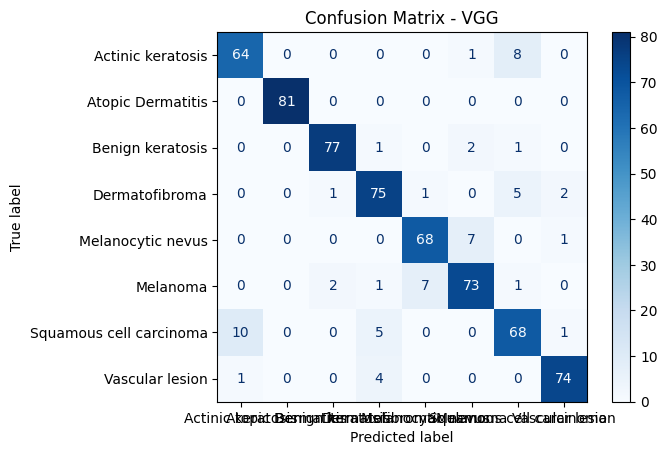


Validation Data Evaluation:
Evaluating Model: VGG


<Figure size 1000x800 with 0 Axes>

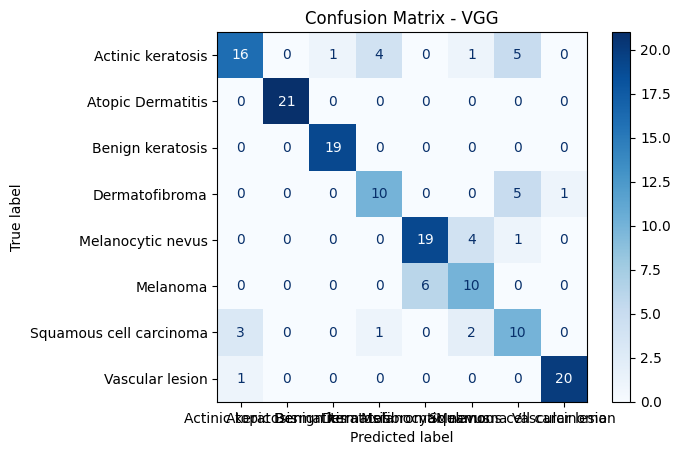

Train Accuracy: 90.34%
Validation Accuracy: 78.12%


In [40]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def calculate_accuracy_and_confusion_matrix(model, data_loader, device, class_names):
    """
    Calculate accuracy and generate a confusion matrix for the model.
    Args:
        model: The trained model.
        data_loader: DataLoader for the dataset.
        device: Device to run the model (e.g., 'cuda' or 'cpu').
        class_names: List of class names for the confusion matrix.
    Returns:
        Accuracy as a percentage.
    """
    # Print the model being evaluated
    print(f"Evaluating Model: {model.__class__.__name__}")

    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for data, labels in data_loader:
            # Move data to the specified device
            data, labels = data.to(device), labels.to(device)

            # Forward pass
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)  # Get predicted class indices

            # Collect predictions and true labels
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    accuracy = (all_predictions == all_labels).mean() * 100

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Plot confusion matrix as heatmap
    plt.figure(figsize=(10, 8))
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.show()

    return accuracy


# Assuming you have a trained model, DataLoader, and class names
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# List of class names for your dataset
class_names = ['Actinic keratosis',
    'Atopic Dermatitis',
    'Benign keratosis',
    'Dermatofibroma',
    'Melanocytic nevus',
    'Melanoma',
    'Squamous cell carcinoma',
    'Vascular lesion']

# Calculate accuracy and generate confusion matrix for train_loader
print("\nTrain Data Evaluation:")
train_accuracy = calculate_accuracy_and_confusion_matrix(model, train_loader, device, class_names)

# Calculate accuracy and generate confusion matrix for val_loader
print("\nValidation Data Evaluation:")
val_accuracy = calculate_accuracy_and_confusion_matrix(model, val_loader, device, class_names)

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")


In [ ]:
#without CONFUSION MATRIX
import torch

def calculate_accuracy(model, data_loader, device):
    """
    Calculate accuracy of the model on a given DataLoader.
    Calculate accuracy and generate a confusion matrix for the model.
    Args:
        model: The trained model.
        data_loader: DataLoader for train or validation set.
        device: Device to run the model (e.g., 'cuda' or 'cpu').
        class_names: List of class names for the confusion matrix.
    Returns:
        Accuracy as a percentage.
    """
    # Print the name of the model being evaluated
    print(f"Evaluating Model: {model.__class__.__name__}")
    
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for data, labels in data_loader:
            # Move data to the specified device
            data, labels = data.to(device), labels.to(device)

            # Forward pass
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)  # Get predicted class indices

            # Update the counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    return accuracy


# Assuming you have a trained model and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print the model's name
print(f"Model Name: {model.__class__.__name__}")

# Calculate accuracy for train_loader and val_loader
train_accuracy = calculate_accuracy(model, train_loader, device)
val_accuracy = calculate_accuracy(model, val_loader, device)

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Model Name: VGG
Evaluating Model: VGG


KeyboardInterrupt: 